In [6]:
%matplotlib inline

# setup
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import selectivesearch as ss
import skimage.data
import time

# Test Selective Search Algorithm

This algorithm is adopted from [this repo](https://github.com/AlpacaDB/selectivesearch). Currently the algorithm is quite slow (~30s for a single image).

In [12]:
# test selective search
img = skimage.data.astronaut()
ss_start = time.time()
img_lbl, regions = ss.selective_search(img, scale=500, sigma=0.9, min_size=10)
ss_end = time.time()
print 'Selective search cost %.3f s' % (ss_end-ss_start)
print 'Found %d regions before filtering' % len(regions)
print 'Example 10 regions:'
print regions[:10]

Selective search cost 29.001 s
Found 2212 regions before filtering
Example 10 regions:
[{'labels': [0.0], 'rect': (0, 0, 15, 24), 'size': 260}, {'labels': [1.0], 'rect': (13, 0, 1, 12), 'size': 23}, {'labels': [2.0], 'rect': (0, 15, 15, 11), 'size': 30}, {'labels': [3.0], 'rect': (15, 14, 0, 0), 'size': 1}, {'labels': [4.0], 'rect': (0, 0, 61, 153), 'size': 4927}, {'labels': [5.0], 'rect': (0, 12, 61, 142), 'size': 177}, {'labels': [6.0], 'rect': (7, 54, 6, 17), 'size': 8}, {'labels': [7.0], 'rect': (28, 50, 18, 32), 'size': 22}, {'labels': [8.0], 'rect': (2, 99, 7, 24), 'size': 24}, {'labels': [9.0], 'rect': (14, 118, 79, 117), 'size': 4008}]


In [13]:
# filtering
candidates = set() # a set of rectangles
for r in regions:
    if r['rect'] in candidates:
        continue
    if r['size'] < 2000: # min patch size threshold
        continue
    x, y, h, w = r['rect']
    if w/h > 1.2 or h/w > 1.2: # distorted
        continue
    candidates.add(r['rect'])
print 'Number of candidates: %d' % len(candidates)

Number of candidates: 49


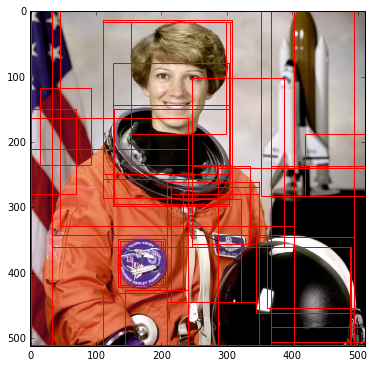

In [14]:
# draw the image
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img)
for x, y, h, w in candidates:
    ax.add_patch(patches.Rectangle((x,y), h, w, fill=False, edgecolor='red'))
plt.show()

# Setup Fast R-CNN

Fast R-CNN needs to be initialized first. There're two major steps: get the right path for `prototxt` and `caffemodel`, then initialize caffe.

In [27]:
import _init_paths # setup environment variables
import os
import caffe
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect

CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

NETS = {'vgg16': ('VGG16',
                  'vgg16_fast_rcnn_iter_40000.caffemodel'),
        'vgg_cnn_m_1024': ('VGG_CNN_M_1024',
                           'vgg_cnn_m_1024_fast_rcnn_iter_40000.caffemodel'),
        'caffenet': ('CaffeNet',
                     'caffenet_fast_rcnn_iter_40000.caffemodel')}

# setup variables
print 'Current root directory:', cfg.ROOT_DIR
demo_net   = 'caffenet' # model that can fit in the memory
prototxt   = os.path.join(cfg.ROOT_DIR, 'models', NETS[demo_net][0], 'test.prototxt')
caffemodel = os.path.join(cfg.ROOT_DIR, 'data', 'fast_rcnn_models', NETS[demo_net][1])
print 'Prototxt file name:', prototxt
print 'Caffe model file name:', caffemodel
assert os.path.isfile(prototxt)
assert os.path.isfile(caffemodel)

# setup environment
caffe.set_mode_gpu()
caffe.set_device(0) # default gpu id
net = caffe.Net(prototxt, caffemodel, caffe.TEST)

Current root directory: /home/rz3515/projects/fast-rcnn
Prototxt file name: /home/rz3515/projects/fast-rcnn/models/CaffeNet/test.prototxt
Caffe model file name: /home/rz3515/projects/fast-rcnn/data/fast_rcnn_models/caffenet_fast_rcnn_iter_40000.caffemodel


# Call Fast R-CNN

The core function for fast r-cnn detection is `im_detect(...)`, it takes a neural net configuration object, an image, and a set of region rectangle boxes.

## Astronaut example

First use the `candidates` calculated above.

In [32]:
detect_start = time.time()
scores, boxes = im_detect(net, img, np.array(list(candidates)))
detect_end = time.time()
print 'Detection took %.3f s' % (detect_end-detect_start)
print 'Shape of scores:', scores.shape

Detection took 0.055 s
Shape of scores: (49, 21)
